<a href="https://colab.research.google.com/github/bongakcsstudent/CCS8_GitHub_Repo/blob/main/Python_CCS8_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import mnist
import tensorflow as tf
tf.test.gpu_device_name()
np.seterr(over='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
idx_train_0 = np.where(y_train == 0)[0]
idx_train_1 = np.where(y_train == 1)[0]
idx_test_0 = np.where(y_test == 0)[0]
idx_test_1 = np.where(y_test == 1)[0]

X_train = np.concatenate((X_train[idx_train_0], X_train[idx_train_1]), axis=0)
y_train = np.concatenate((y_train[idx_train_0], y_train[idx_train_1]), axis=0)
X_test = np.concatenate((X_test[idx_test_0], X_test[idx_test_1]), axis=0)
y_test = np.concatenate((y_test[idx_test_0], y_test[idx_test_1]), axis=0)

In [4]:
print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test:  '  + str(y_test.shape))

X_train: (12665, 28, 28)
Y_train: (12665,)
X_test:  (2115, 28, 28)
Y_test:  (2115,)


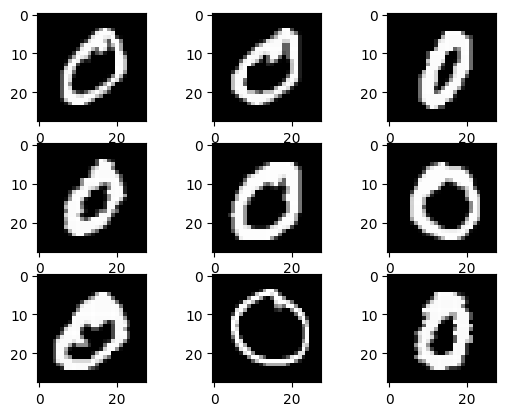

In [5]:
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
plt.show()

In [6]:
def standardize(X,X_train):
    return (X-np.mean(X_train,axis=0))/(np.std(X_train,axis=0) + 1e-7) # we need epsilon for feature (pixel) that has zero variance

In [7]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train=X_train.reshape(X_train.shape[0],-1)
X_test=X_test.reshape(X_test.shape[0],-1)

In [8]:
def Shuffle(X,y):

    indices = np.arange(X.shape[0])

    np.random.shuffle(indices)

    X = X[indices]
    y = y[indices]
    return X,y

In [9]:

def K_Folds(X,y,k):
    Fold_size=((100/k)/100) * X.shape[0]
    Fold_start=0
    Fold_limit=0

    Folds={

    }
    for i in range(k):
        Fold_limit+=Fold_size

        Folds['Fold'+str(i+1)]=[X[int(Fold_start):int(Fold_limit)],y[int(Fold_start):int(Fold_limit)]]
        Fold_start=Fold_limit
    return Folds

In [10]:

def CVs(Folds,k):

    train_val_CV={

    }

    for i in range(k):

        X_train_Fold=np.zeros(Folds['Fold'+str(1)][0].shape)
        y_train_Fold=np.zeros(Folds['Fold'+str(1)][1].shape)

        X_val_Fold,y_val_Fold=Folds['Fold'+str(i+1)][0],Folds['Fold'+str(i+1)][1]
        cn=0
        for j in range(k):
            if i!=j:
                X_train_Fold_j,y_train_Fold_j=Folds['Fold'+str(j+1)][0],Folds['Fold'+str(j+1)][1]

                if cn==0:
                    X_train_Fold=X_train_Fold_j
                    y_train_Fold=y_train_Fold_j
                    cn+=1
                else:

                    X_train_Fold=np.concatenate((X_train_Fold,X_train_Fold_j), axis=0)
                    y_train_Fold=np.concatenate((y_train_Fold, y_train_Fold_j), axis=0)

        train_val_CV['CV'+str(i+1)]=[X_train_Fold,y_train_Fold,X_val_Fold,y_val_Fold]
    return train_val_CV

In [11]:
def Accuracy(y_pred,y_test):

    Acc=(np.sum(y_pred==y_test)/len(y_test)) * 100
    return round(Acc,1)

In [12]:
def Error(y_pred,y_test):
    return np.sum((y_test * np.log(y_pred+1e-10) + (1-y_test) * np.log(1-y_pred+1e-10))) * -1/len(y_test)

In [13]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [14]:
def Logistic_Regression(X,y,epochs,eta):
    W=np.random.randn(X.shape[1])
    b=np.random.randn()
    error=0

    for j in range(epochs):
        yhat= np.dot(W,X.T) + b

        Z=sigmoid(yhat)
        error= Error(Z,y)

        W= W - eta * np.mean((Z-y) * X.T)
        b= b- eta * np.mean(Z-y)

    print("Training_Error: ",error)
    return W,b

In [15]:

def test_model(W,b,X_test,y_test):
    y_pred= np.dot(W,X_test.T) + b
    Z=sigmoid(y_pred)
    Z[Z<0.5]=0
    Z[Z>0.5]=1
    return Accuracy(Z.astype(np.int32),y_test)

In [16]:
def train_CVs(train_val_CV,k,eta):
    epochs=1500
    Accs=np.zeros(k)

    for i in range(k):
        W,b=Logistic_Regression(train_val_CV['CV'+str(i+1)][0],train_val_CV['CV'+str(i+1)][1],epochs,eta)
        Acc=test_model(W,b,train_val_CV['CV'+str(i+1)][2],train_val_CV['CV'+str(i+1)][3])
        Accs[i]=Acc
    print("----------------------------------------------------------------------------------")

    return round(np.mean(Accs),1)

In [17]:
def Acc_eta(train_val_CV,k):
    eta=[0.1,0.01,0.001,0.0001]
    Avg_Accs=np.zeros(len(eta))

    eta_and_Acc={

    }
    for i in range(len(eta)):
        eta_and_Acc[eta[i]]=train_CVs(train_val_CV,k,eta[i])

    return eta_and_Acc

In [ ]:
def K_Fold_CV(X,y,k):
    X,y=Shuffle(X,y)
    Folds=K_Folds(X,y,k)
    train_val_CV=CVs(Folds,k)
    eta_and_Acc=Acc_eta(train_val_CV,k)
    return eta_and_Acc

eta_and_Acc=K_Fold_CV(X_train,y_train,10)
print("Learning rates and their Accuracies: ",eta_and_Acc)

Training_Error:  12.235071416976503
